<a href="https://colab.research.google.com/github/Acarreno96/Mine/blob/main/Class_8_Assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I feel that the features on my model make sense for detecting ATO. For example; how often a person logs in, the time of the day they are accessing their acct, and also how much money is being moved. These could be things we see in real ATO behavior. I think it shows we are on the right track.

The results might be a bit wonky. The model seems to have predicted "Not Fraud" which could be interpreted as the "majority class". Which is expected since I did not attempt to balance the class. So it not learning to detect rare fraud. We can see the imbalance just by look at the left side of the model. Where the Fraud is showing as 109 and the Not Fraud is showing as 8911. Which could be hard to think all that was "Not Fraud"

I think the features are good; but the model does need some balancing.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30066 entries, 0 to 30065
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     30066 non-null  object 
 1   timestamp   30066 non-null  object 
 2   event_type  30066 non-null  object 
 3   ip_address  30066 non-null  object 
 4   location    30066 non-null  object 
 5   device_id   30066 non-null  object 
 6   amount      30066 non-null  float64
 7   is_fraud    30066 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.8+ MB

Post-Imputation Summary:

                           timestamp        amount     is_fraud   hour_of_day  \
count                          30066  30066.000000  30066.00000  30066.000000   
mean   2023-08-05 15:25:32.556376064     10.117300      0.01194     11.441362   
min              2023-01-01 04:34:00      0.000000      0.00000      0.000000   
25%              2023-05-07 17:48:15      0.000000      0.00000      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


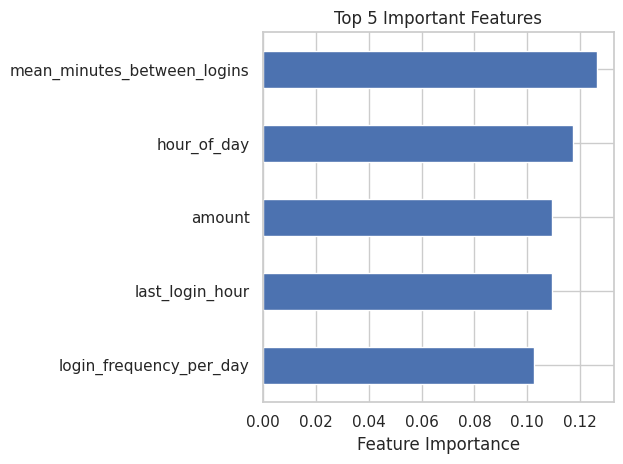

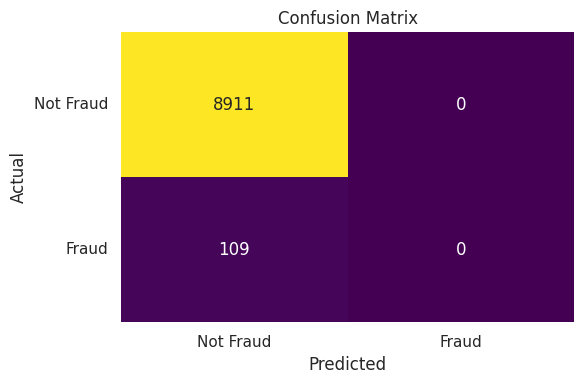

In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
precision_score, recall_score, f1_score, roc_auc_score)


pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

df = pd.read_csv('ato_transactions.csv')
df.head()

df.info()
df.describe()
df.value_counts()

df= df.drop(['ip_address', 'device_id'], axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['is_off_hours'] = df['hour_of_day'].apply(lambda x: 1 if x < 6 else 0)

df = df.fillna(df.median(numeric_only=True))
print("\nPost-Imputation Summary:\n")
print(df.describe())

df = df.sort_values(by=['user_id', 'timestamp'])

login_df = df[df['event_type'] == 'login'].copy()

login_df['prev_login_time'] = login_df.groupby('user_id')['timestamp'].shift(1)
login_df['login_time_diff'] = (login_df['timestamp'] - login_df['prev_login_time']).dt.total_seconds() / 60

login_features = pd.concat([
    login_df.groupby('user_id').size().rename('num_logins'),
    login_df.groupby('user_id')['location'].nunique().rename('new_login_locations'),
    login_df.groupby('user_id')['login_time_diff'].mean().rename('mean_minutes_between_logins'),
    login_df.groupby('user_id')['timestamp'].agg(['min', 'max']).pipe(lambda df_: (
        (df_.groupby('user_id').size() / ((df_['max'] - df_['min']).dt.days + 1))
    )).rename('login_frequency_per_day'),
    login_df.groupby('user_id')['timestamp'].max().dt.hour.rename('last_login_hour'),
    login_df.assign(rapid_login=login_df['login_time_diff'] <= 10)
            .groupby('user_id')['rapid_login'].sum().rename('rapid_logins_within_10min')
], axis=1).reset_index()

df = df.merge(login_features, on='user_id', how='left')

reset_df = df[df['event_type'] == 'reset_password'].copy()
reset_df['prev_reset_time'] = reset_df.groupby('user_id')['timestamp'].shift(1)
reset_df['reset_time_diff'] = (reset_df['timestamp'] - reset_df['prev_reset_time']).dt.total_seconds() / 60

reset_features = pd.concat([
    reset_df.groupby('user_id').size().rename('num_resets'),
    reset_df.groupby('user_id')['location'].nunique().rename('unique_reset_locations'),
    reset_df.groupby('user_id')['reset_time_diff'].mean().rename('mean_minutes_between_resets'),
    reset_df.groupby('user_id')['timestamp'].agg(['min', 'max']).pipe(lambda df_: (
        (df_.groupby('user_id').size() / ((df_['max'] - df_['min']).dt.days + 1))
    )).rename('reset_frequency_per_day'),
    reset_df.groupby('user_id')['timestamp'].max().dt.hour.rename('last_reset_hour'),
    reset_df.assign(rapid_reset=reset_df['reset_time_diff'] <= 10)
             .groupby('user_id')['rapid_reset'].sum().rename('rapid_resets_within_10min')
], axis=1).reset_index()

df = df.merge(reset_features, on='user_id', how='left')
print(df.head())

df = pd.get_dummies(df, columns=['event_type', 'location', 'day_of_week'], drop_first=True)

X = df.drop(columns=['is_fraud', 'user_id','timestamp'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

split_test_summary = {
    'Test Set Size': len(y_test),
    'Fraud Cases in Test Set': int(sum(y_test)),
    'Legit Cases in Test Set': int(len(y_test) - sum(y_test))}

print("\n📊 Split Test Summary:")
for key, value in split_test_summary.items():
    print(f"{key}: {value}")

top5.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 5 Important Features")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ['Not Fraud', 'Fraud'])
plt.yticks([0.5, 1.5], ['Not Fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()
